In [19]:
%matplotlib inline
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os
from math import sqrt

In [10]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

In [11]:
os.getcwd()

'/Users/shell/Labs/wijst'

In [24]:
# load raw counts matrix as scipy sparse matrix with cells as rows and genes as cols

input_dir = 'raw/filtered_feature_bc_matrix'
counts_matrix = scipy.io.mmread(input_dir + '/matrix.mtx').T.tocsc()
genes = np.array(scr.load_genes(input_dir + '/features.tsv', delimiter='\t', column=1))

print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
print('Number of genes in gene list: {}'.format(len(genes)))

Counts matrix shape: 11898 rows, 180488 columns
Number of genes in gene list: 180488


TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [26]:
type(counts_matrix)# scipy.sparse._csc.csc_matrix
# read about scipy.sparse.csc_matrix: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html
counts_matrix.shape
# retrieve n_cells
counts_matrix.shape[0]

11898

In [27]:
n_cells = counts_matrix.shape[0]

scrub = scr.Scrublet(
    counts_matrix, 
    expected_doublet_rate = 0.06, 
    sim_doublet_ratio = 2, 
    n_neighbors = round(0.5*sqrt(n_cells))
)

In [28]:
# run default pipeline: 
# doublet simulation, 
# normalization, gene filtering, rescaling, PCA
# doublet score calculation
# doublet score threshold detection and doublet calling
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                         min_cells=3, 
                                                         min_gene_variability_pctl=85, 
                                                         n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.16
Detected doublet rate = 7.6%
Estimated detectable doublet fraction = 64.0%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 11.9%
Elapsed time: 84.4 seconds


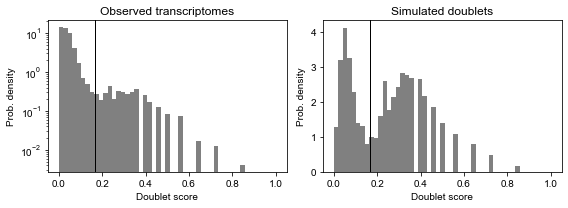

In [29]:
# plot doublet score histograms for 
# observed transcriptomes and simulated doublets

# the simulated doublet histograms is typically bimodal
# left mode: embedded doublets
# right mode: neotypic doublets - scrublet can only detect this type

# threshold doublet score is ideally the min btw two modes of simulated doublet histogram
# if scrub_doublets() does not set a good score at the min
# use call_doublets(threshold=xxx) to modify

scrub.plot_histogram();

In [31]:
print('Running UMAP...')
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
# can change 'UMAP' to tSNE or force layout
# scrub.set_embedding('tSNE', scr.get_tsne(scrub.manifold_obs_, angle=0.9))
# scrub.set_embedding('FA', scr.get_force_layout(scrub.manifold_obs_, n_neighbors=5. n_iter=1000))
print('Done.')

Running UMAP...
Done.


(<Figure size 576x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <AxesSubplot:title={'center':'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

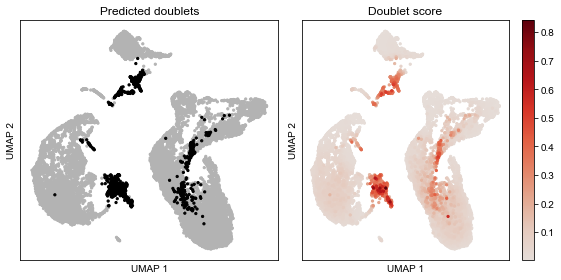

In [32]:
# plot doublet predictions on 2D embedding
# predicted doublets should co-localize in distinct states
scrub.plot_embedding('UMAP', order_points=True)
# you can do the same for "tSNE" and "FA"

In [35]:
len(scrub.predicted_doublets_)
# 11898
scrub.predicted_doublets_[0:4]
# array([False, False, False, False])
sum([False,True,False])
# 1
sum(scrub.predicted_doublets_)
# 904
scrub.doublet_scores_obs_[0:4]
# array([0.07137097, 0.06949119, 0.04769327, 0.00722218])

array([0.07137097, 0.06949119, 0.04769327, 0.00722218])

In [42]:
f = open('raw/filtered_feature_bc_matrix/barcodes.tsv','r')
barcodes = f.read().split()
f.close()
len(barcodes)# length looks right
barcodes[0:4]# format looks right
# developer confirms that barcode order is the same as input
# I can just add doublet labels to the barcodes

In [47]:
w = open('out/scrublet_predictions.csv','a+')
for barcode,label in zip(barcodes,scrub.predicted_doublets_):
    w.write(f'{barcode},{label}\n')
w.close()